In [1]:
import numpy as np
import pandas as pd

In [2]:
labels = np.array(pd.read_csv("train_samples_updated.csv"))[:, 5:]
labels.shape
rgb_1_train = np.load("final_swin_rgb_train_view1.npy")
rgb_0_train = np.load("final_swin_rgb_train_view0.npy")
rgb_2_train = np.load("final_swin_rgb_train_view2.npy")
print(rgb_1_train.shape, rgb_0_train.shape, rgb_2_train.shape)

rgb_1_val = np.load("final_swin_rgb_val_view1.npy")
rgb_0_val = np.load("final_swin_rgb_val_view0.npy")
rgb_2_val = np.load("final_swin_rgb_val_view2.npy")
print(rgb_1_val.shape, rgb_0_val.shape, rgb_2_val.shape)

dct_1_train = np.load("swin_mul_dct_train_view1.npy")
dct_0_train = np.load("swin_mul_dct_train_view0.npy")
dct_2_train = np.load("swin_mul_dct_train_view2.npy")
print(dct_1_train.shape, dct_0_train.shape, dct_2_train.shape)

dct_1_val = np.load("swin_mul_dct_val_view1.npy")
dct_0_val = np.load("swin_mul_dct_val_view0.npy")
dct_2_val = np.load("swin_mul_dct_val_view2.npy")
print(dct_1_val.shape, dct_0_val.shape, dct_2_val.shape)

(29955, 1024) (29955, 1024) (29955, 1024)
(11495, 1024) (11495, 1024) (11495, 1024)
(29955, 1024) (29955, 1024) (29955, 1024)
(11495, 1024) (11495, 1024) (11495, 1024)


In [3]:
val_labels = np.array(pd.read_csv("val_samples_updated.csv"))[:, 5:]

In [4]:
train_transformer = np.load("train_transformer_10.npy")
val_transformer = np.load("val_transformer_10.npy")

In [5]:
train_transformer.shape, val_transformer.shape

((29955, 768), (11495, 768))

In [6]:
import numpy as np
# import pandas as pd
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.layers import merge
# from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense, concatenate,multiply, LayerNormalization, Add
# from sklearn.linear_model import Ridge
from keras.layers import Lambda

2023-07-11 11:35:21.606128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:35:22.086504: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 11:35:22.272444: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-11 11:35:24.174703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [7]:
def split_tensor(X):
  s0, s1, s2 = tf.split(X, num_or_size_splits=3,axis = -1)
  return s0,s1,s2

def mul_sca(x):
    return tf.multiply(x[0],x[1])

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# seqLen = chunk_size-1
# seqLen = 14

#Middle Input LSTM
rgb_input_1 = Input(shape=(1024), name='input_rgb_1')
rgb_output_1 = Dense(128, activation='relu', name='output_rgb_1')(rgb_input_1)

#Middle Input LSTM
rgb_input_2 = Input(shape=(1024), name='input_rgb_2')
rgb_output_2 = Dense(128, activation='relu')(rgb_input_2)

#Right Input LSTM
rgb_input_3 = Input(shape=(1024), name='input_rgb_3')
rgb_output_3 = Dense(128, activation='relu')(rgb_input_3)


#Middle Input LSTM
dct_input_1 = Input(shape=(1024), name='input_dct_1')
dct_output_1 = Dense(128, activation='relu', name='output_dct_1')(dct_input_1)

#Middle Input LSTM
dct_input_2 = Input(shape=(1024), name='input_dct_2')
dct_output_2 = Dense(128, activation='relu')(dct_input_2)

#Right Input LSTM
dct_input_3 = Input(shape=(1024), name='input_dct_3')
dct_output_3 = Dense(128, activation='relu')(dct_input_3)




# layer = tf.keras.layers.LayerNormalization(axis=-1)
rgb_1_nor_output = LayerNormalization()(rgb_output_1)
rgb_2_nor_output = LayerNormalization()(rgb_output_2)
rgb_3_nor_output = LayerNormalization()(rgb_output_3)


dct_1_nor_output = LayerNormalization()(dct_output_1)
dct_2_nor_output = LayerNormalization()(dct_output_2)
dct_3_nor_output = LayerNormalization()(dct_output_3)


#Merged Layer
merged_rgb = concatenate([rgb_output_1, rgb_output_2, rgb_output_3], name='RGB_Concatenate')
merge_dense_rgb = Dense(128, activation='relu')(merged_rgb)
softmax_output_rgb = Dense(3, activation='softmax', name='soft_score_rgb')(merge_dense_rgb)
weight_rgb1, weight_rgb2,weight_rgb3 = Lambda(split_tensor)(softmax_output_rgb)

score_rgb1 = Lambda(mul_sca)([rgb_1_nor_output, weight_rgb1])
score_rgb2 = Lambda(mul_sca)([rgb_2_nor_output, weight_rgb2])
score_rgb3 = Lambda(mul_sca)([rgb_3_nor_output, weight_rgb3])
additive_score_rgb = Add()([score_rgb1, score_rgb2, score_rgb3])



merged_dct = concatenate([dct_output_1, dct_output_2, dct_output_3], name='DCT_Concatenate')
merge_dense_dct = Dense(128, activation='relu')(merged_dct)
softmax_output_dct = Dense(3, activation='softmax', name='soft_score_dct')(merge_dense_dct)
weight_dct1, weight_dct2,weight_dct3 = Lambda(split_tensor)(softmax_output_dct)

score_dct1 = Lambda(mul_sca)([dct_1_nor_output, weight_dct1])
score_dct2 = Lambda(mul_sca)([dct_2_nor_output, weight_dct2])
score_dct3 = Lambda(mul_sca)([dct_3_nor_output, weight_dct3])
additive_score_dct = Add()([score_dct1, score_dct2, score_dct3])


transformer_features = Input(shape=(768), name='transformer')
trans_output= Dense(128, activation='relu', name='output_trans_1')(transformer_features)
tran_nor_output = LayerNormalization()(trans_output)



# rgb_dct_concat = concatenate([additive_score_rgb, additive_score_dct, tran_nor_output], name='rgb_dct_Concatenate')
rgb_dct_concat = Add()([additive_score_rgb, additive_score_dct, tran_nor_output])

final_model_output11 = Dense(256, activation='relu')(rgb_dct_concat)
final_model_output12 = Dense(128, activation='relu')(final_model_output11)
final_model_output = Dense(14, activation='sigmoid')(final_model_output11)

final_model = Model(inputs=[rgb_input_1, rgb_input_2, rgb_input_3, dct_input_1, dct_input_2, dct_input_3, transformer_features], outputs=final_model_output,name='Final_output')

# opt = keras.optimizers.Adam(learning_rate=0.01) #Optimizer
# final_model.compile(optimizer = opt, loss = 'binary_crossentropy')

2023-07-11 11:35:31.348970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 11:35:32.890099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6119 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [9]:
final_model.summary()

Model: "Final_output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_rgb_1 (InputLayer)       [(None, 1024)]       0           []                               
                                                                                                  
 input_rgb_2 (InputLayer)       [(None, 1024)]       0           []                               
                                                                                                  
 input_rgb_3 (InputLayer)       [(None, 1024)]       0           []                               
                                                                                                  
 input_dct_1 (InputLayer)       [(None, 1024)]       0           []                               
                                                                                       

 lambda_6 (Lambda)              (None, 128)          0           ['layer_normalization_4[0][0]',  
                                                                  'lambda_4[0][1]']               
                                                                                                  
 lambda_7 (Lambda)              (None, 128)          0           ['layer_normalization_5[0][0]',  
                                                                  'lambda_4[0][2]']               
                                                                                                  
 output_trans_1 (Dense)         (None, 128)          98432       ['transformer[0][0]']            
                                                                                                  
 add (Add)                      (None, 128)          0           ['lambda_1[0][0]',               
                                                                  'lambda_2[0][0]',               
          

In [11]:

opt = keras.optimizers.SGD(learning_rate=0.0002) #Optimizer
final_model.compile(optimizer = opt, loss = 'binary_crossentropy')


In [12]:
zero_bias_history = final_model.fit([rgb_1_train, rgb_0_train, rgb_2_train, dct_1_train, dct_0_train, dct_2_train, train_transformer], labels, epochs = 200, batch_size = 32, validation_split = 0.1, callbacks = [callback])


Epoch 1/200


2023-07-11 11:37:08.939907: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


843/843 [==============================] - 17s 15ms/step - loss: 0.5389 - val_loss: 0.2954
Epoch 2/200
843/843 [==============================] - 12s 14ms/step - loss: 0.3180 - val_loss: 0.1760
Epoch 3/200
843/843 [==============================] - 12s 14ms/step - loss: 0.2433 - val_loss: 0.1261
Epoch 4/200
843/843 [==============================] - 12s 14ms/step - loss: 0.2083 - val_loss: 0.1014
Epoch 5/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1883 - val_loss: 0.0874
Epoch 6/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1752 - val_loss: 0.0787
Epoch 7/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1656 - val_loss: 0.0726
Epoch 8/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1582 - val_loss: 0.0681
Epoch 9/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1522 - val_loss: 0.0647
Epoch 10/200
843/843 [==============================] - 12s 14ms/step - loss: 0.1471 

Epoch 80/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0834 - val_loss: 0.0331
Epoch 81/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0832 - val_loss: 0.0330
Epoch 82/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0830 - val_loss: 0.0329
Epoch 83/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0828 - val_loss: 0.0328
Epoch 84/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0826 - val_loss: 0.0328
Epoch 85/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0824 - val_loss: 0.0327
Epoch 86/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0822 - val_loss: 0.0326
Epoch 87/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0820 - val_loss: 0.0325
Epoch 88/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0818 - val_loss: 0.0324
Epoch 89/200
843/843 [==============================] - 12s 14ms

843/843 [==============================] - 12s 14ms/step - loss: 0.0739 - val_loss: 0.0296
Epoch 159/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0739 - val_loss: 0.0295
Epoch 160/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0738 - val_loss: 0.0294
Epoch 161/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0737 - val_loss: 0.0294
Epoch 162/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0736 - val_loss: 0.0294
Epoch 163/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0736 - val_loss: 0.0294
Epoch 164/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0735 - val_loss: 0.0294
Epoch 165/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0734 - val_loss: 0.0294
Epoch 166/200
843/843 [==============================] - 12s 14ms/step - loss: 0.0734 - val_loss: 0.0294
Epoch 167/200
843/843 [==============================] - 12s 14ms/ste

In [13]:
predict = final_model.predict([rgb_1_val, rgb_0_val, rgb_2_val, dct_1_val, dct_0_val, dct_2_val, val_transformer])

predict

360/360 [==============================] - 3s 7ms/step


array([[7.2167611e-01, 1.2544810e-03, 8.0380979e-04, ..., 1.5313406e-02,
        1.7198240e-03, 8.3001658e-02],
       [3.4547905e-03, 8.8098430e-04, 5.5627548e-04, ..., 3.7616710e-04,
        3.4920700e-04, 6.0624019e-03],
       [1.6556049e-02, 9.8224652e-01, 1.0141628e-01, ..., 6.5930905e-03,
        3.6166213e-03, 1.8746369e-03],
       ...,
       [2.3378115e-03, 9.8669863e-01, 2.2888182e-02, ..., 2.8816076e-02,
        2.0953901e-03, 1.1970704e-02],
       [2.0231081e-03, 8.7406319e-01, 1.0918675e-03, ..., 1.1746809e-02,
        9.4068717e-05, 1.5673261e-03],
       [3.4824794e-03, 7.0239377e-01, 1.4553796e-03, ..., 1.9327656e-03,
        2.9445440e-03, 1.2831068e-02]], dtype=float32)

In [14]:
train_csv_file = pd.read_csv("val_samples_updated.csv")

col_names = ['rec_no', 'subject_pos', 'start_time', 'end_time' ]
new_train_csv = train_csv_file.drop(col_names, axis=1)

#preparing train and test csv
test_csv = new_train_csv
# train_csv = new_train_csv[3123:]
print(len(test_csv))

Column_names = ['Settle','Legs crossed','Groom','Hand-mouth','Fold arms','Leg movement','Scratch','Gesture','Hand-face','Adjusting clothing','Fumble','Shrug','Stretching','Smearing hands']
# Column_names = ['Hand-face','Hand-mouth','Gesture','Fumble','Scratch','Stretching','Smearing hands','Shrug','Adjusting clothing','Groom','Fold arms','Leg movement','Settle','Legs crossed']
extracted_col = test_csv["sample_id"]
test_pred_csv = pd.DataFrame(predict, columns = Column_names)
test_pred_csv.insert(0, "sample_id", extracted_col)
# test_pred_csv.to_csv("test_predicted_dct_swin_fusion_"  + ".csv", index=False)

11495


In [15]:

test_pred_csv

,sample_id,Settle,Legs crossed,Groom,Hand-mouth,Fold arms,Leg movement,Scratch,Gesture,Hand-face,Adjusting clothing,Fumble,Shrug,Stretching,Smearing hands
0,42222,0.721676,0.001254,0.000804,0.001142,0.012255,0.075421,0.031206,0.473381,0.005236,0.053450,0.031643,0.015313,0.001720,0.083002
1,5609,0.003455,0.000881,0.000556,0.000526,0.000350,0.002693,0.001389,0.016492,0.000138,0.000789,0.064052,0.000376,0.000349,0.006062
2,41081,0.016556,0.982247,0.101416,0.041194,0.000775,0.038909,0.100239,0.047823,0.603808,0.014184,0.087154,0.006593,0.003617,0.001875
3,6959,0.013129,0.348942,0.000694,0.001908,0.001133,0.014764,0.192172,0.278216,0.000412,0.129234,0.110438,0.003452,0.003004,0.126212
4,2744,0.051484,0.004337,0.023673,0.732870,0.004435,0.015188,0.017428,0.013467,0.805200,0.009335,0.017707,0.001993,0.009346,0.009824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11490,7675,0.010673,0.979743,0.004417,0.002252,0.000155,0.005763,0.003949,0.139331,0.005106,0.012083,0.055603,0.005067,0.000949,0.037766
11491,38967,0.006779,0.973820,0.002971,0.005985,0.000252,0.000510,0.015686,0.011984,0.014177,0.015787,0.897788,0.008684,0.000928,0.004729
11492,39394,0.002338,0.986699,0.022888,0.073783,0.001129,0.001395,0.022980,0.959129,0.053676,0.017269,0.038944,0.028816,0.002095,0.011971
11493,5006,0.002023,0.874063,0.001092,0.002899,0.000889,0.001683,0.013653,0.008696,0.000702,0.029340,0.027728,0.011747,0.000094,0.001567


In [16]:
test_csv

,sample_id,Settle,Legs crossed,Groom,Hand-mouth,Fold arms,Leg movement,Scratch,Gesture,Hand-face,Adjusting clothing,Fumble,Shrug,Stretching,Smearing hands
0,42222,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,5609,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41081,0,1,0,0,0,1,0,0,1,0,0,0,0,0
3,6959,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,2744,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11490,7675,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11491,38967,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11492,39394,0,1,0,0,0,0,0,0,0,0,0,0,0,0
11493,5006,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
import pandas as pd, numpy as np
from sklearn.metrics import average_precision_score


CLASSES = ['Hand-face','Hand-mouth','Gesture','Fumble','Scratch','Stretching','Smearing hands','Shrug','Adjusting clothing','Groom','Fold arms','Leg movement','Settle','Legs crossed']


def evaluate(test_annotation_file,user_submission_file):
#     test = pd.read_csv(test_annotation_file,index_col="sample_id").sort_values('sample_id')
#     user = pd.read_csv(user_submission_file,index_col="sample_id").sort_values('sample_id')
    
    test = test_annotation_file.sort_values('sample_id')
    
    user = user_submission_file.sort_values('sample_id')
    if not(np.all(test.index==user.index)):
        raise ValueError("Indexes of test and prediction files do not agree.")
        
    scores = []
    for behaviour in CLASSES:
        cur_score = average_precision_score(test[behaviour].values,user[behaviour].values)
        scores.append(cur_score)
    per_class_scores = pd.DataFrame({'behaviour':CLASSES,'score':scores}).set_index('behaviour')
    macro_average = np.mean(scores)
    return {'macro_average':macro_average,'per_class_scores':per_class_scores}



if __name__=='__main__':
    # example usage of evaluate function
    test_annotation_file = test_csv
    user_submission_file = test_pred_csv # use your own predictions here
    results = evaluate(test_annotation_file,user_submission_file)
    print('')
    print('--------------- MACRO AVERAGE: -----------------')
    print('')
    print(str(results['macro_average']))
    print('')
    print('--------------- PER CLASS: ---------------------')
    print(str(results['per_class_scores']))



--------------- MACRO AVERAGE: -----------------

0.4323252853112164

--------------- PER CLASS: ---------------------
                       score
behaviour                   
Hand-face           0.669718
Hand-mouth          0.463703
Gesture             0.822986
Fumble              0.542059
Scratch             0.218037
Stretching          0.007711
Smearing hands      0.080788
Shrug               0.022374
Adjusting clothing  0.160421
Groom               0.564910
Fold arms           0.914963
Leg movement        0.322668
Settle              0.362839
Legs crossed        0.899379


In [18]:
final_model.save("fusion_model_0.478")

INFO:tensorflow:Assets written to: fusion_model_0.478/assets


In [19]:
test_transformer = np.load("test_transformer_10.npy")

rgb_1_test = np.load("final_swin_rgb_test_view1.npy")
rgb_0_test = np.load("final_swin_rgb_test_view0.npy")
rgb_2_test = np.load("final_swin_rgb_test_view2.npy")

dct_1_test = np.load("swin_mul_dct_test_view1.npy")
dct_0_test = np.load("swin_mul_dct_test_view0.npy")
dct_2_test = np.load("swin_mul_dct_test_view2.npy")

print(test_transformer.shape)
print(rgb_1_test.shape, rgb_0_test.shape, rgb_2_test.shape, dct_1_test.shape, dct_0_test.shape, dct_2_test.shape )

(995, 768)
(995, 1024) (995, 1024) (995, 1024) (995, 1024) (995, 1024) (995, 1024)


In [20]:
test_predict = final_model.predict([rgb_1_test, rgb_0_test, rgb_2_test, dct_1_test, dct_0_test, dct_2_test, test_transformer])

test_predict

32/32 [==============================] - 0s 7ms/step


array([[2.9320482e-02, 9.8860979e-01, 1.6995013e-01, ..., 4.4187885e-02,
        3.7671386e-03, 9.1459513e-02],
       [1.6431082e-02, 6.7326462e-01, 3.3240864e-01, ..., 1.9509528e-02,
        1.8661291e-03, 1.9940566e-03],
       [1.0642942e-02, 8.1942564e-01, 2.1235193e-01, ..., 8.5835094e-03,
        6.1616767e-04, 4.4060661e-03],
       ...,
       [3.1135710e-02, 8.4803993e-01, 3.3244732e-01, ..., 1.9112824e-02,
        2.7238112e-03, 1.4740263e-02],
       [6.9753653e-03, 9.9829787e-01, 7.2649000e-03, ..., 1.9325552e-03,
        4.0552413e-04, 1.1402801e-01],
       [2.2879785e-03, 9.9334770e-01, 8.6464984e-03, ..., 1.7431770e-03,
        4.1594640e-03, 3.6693584e-02]], dtype=float32)

In [23]:
test_fake_csv_file = pd.read_csv("fake_predictions_test.csv")


# train_csv = new_train_csv[3123:]
print(len(test_fake_csv_file))

Column_names = ['Settle','Legs crossed','Groom','Hand-mouth','Fold arms','Leg movement','Scratch','Gesture','Hand-face','Adjusting clothing','Fumble','Shrug','Stretching','Smearing hands']
# Column_names = ['Hand-face','Hand-mouth','Gesture','Fumble','Scratch','Stretching','Smearing hands','Shrug','Adjusting clothing','Groom','Fold arms','Leg movement','Settle','Legs crossed']
extracted_col = test_fake_csv_file["sample_id"]
test_pred_csv = pd.DataFrame(test_predict, columns = Column_names)
test_pred_csv.insert(0, "sample_id", extracted_col)
test_pred_csv.to_csv("test_predicted_fusion_version_1"  + ".csv", index=False)

995


In [25]:
len(test_fake_csv_file), len(test_pred_csv)

(995, 995)

In [26]:
test_pred_csv

,sample_id,Settle,Legs crossed,Groom,Hand-mouth,Fold arms,Leg movement,Scratch,Gesture,Hand-face,Adjusting clothing,Fumble,Shrug,Stretching,Smearing hands
0,1392,0.029320,0.988610,0.169950,0.000555,0.123927,0.037264,0.333082,0.029093,0.001137,0.466386,0.023504,0.044188,0.003767,0.091460
1,8887,0.016431,0.673265,0.332409,0.001116,0.221470,0.070834,0.365835,0.097871,0.002102,0.061278,0.003748,0.019510,0.001866,0.001994
2,6770,0.010643,0.819426,0.212352,0.002820,0.067777,0.002447,0.048593,0.623338,0.018945,0.004549,0.014818,0.008584,0.000616,0.004406
3,5610,0.079749,0.994479,0.038381,0.004777,0.012125,0.003107,0.035985,0.010117,0.005670,0.021122,0.002894,0.010801,0.008444,0.051897
4,11949,0.007254,0.245459,0.004402,0.004330,0.447743,0.002714,0.049198,0.016582,0.007323,0.000495,0.047346,0.002025,0.002412,0.002299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,9669,0.014890,0.689428,0.002669,0.001104,0.004126,0.057286,0.236441,0.138748,0.000508,0.092288,0.159741,0.013119,0.005657,0.374022
991,7797,0.037858,0.673478,0.001858,0.015436,0.001717,0.011446,0.223009,0.012050,0.188589,0.005283,0.374576,0.017089,0.009583,0.056211
992,9656,0.031136,0.848040,0.332447,0.001667,0.000486,0.164407,0.197649,0.018939,0.014522,0.007963,0.232659,0.019113,0.002724,0.014740
993,1523,0.006975,0.998298,0.007265,0.004096,0.001528,0.008528,0.070042,0.715885,0.012394,0.001872,0.069170,0.001933,0.000406,0.114028


In [22]:
test_fake_csv_file.head()

,sample_id,Settle,Legs crossed,Groom,Hand-mouth,Fold arms,Leg movement,Scratch,Gesture,Hand-face,Adjusting clothing,Fumble,Shrug,Stretching,Smearing hands
0,1392,0.926606,0.767693,0.713928,0.960296,0.929207,0.783461,0.532337,0.959026,0.649793,0.548385,0.777752,0.922528,0.894079,0.387025
1,8887,0.518512,0.821756,0.821083,0.776349,0.334497,0.889758,0.956995,0.688925,0.985291,0.383994,0.707081,0.361350,0.858588,0.893891
2,6770,0.555041,0.749766,0.916792,0.911527,0.575488,0.866515,0.506077,0.566857,0.753052,0.780284,0.901780,0.797214,0.314259,0.817419
3,5610,0.774548,0.839138,0.947893,0.995705,0.832970,0.989658,0.596235,0.789577,0.846172,0.906027,0.815203,0.139659,0.614974,0.422323
4,11949,0.847267,0.946046,0.932860,0.768163,0.425852,0.761930,0.920126,0.995232,0.930819,0.431843,0.468479,0.425297,0.664190,0.779305


In [24]:
import pandas as pd, numpy as np
from sklearn.metrics import average_precision_score


CLASSES = ['Hand-face','Hand-mouth','Gesture','Fumble','Scratch','Stretching','Smearing hands','Shrug','Adjusting clothing','Groom','Fold arms','Leg movement','Settle','Legs crossed']


def evaluate(test_annotation_file,user_submission_file):
#     test = pd.read_csv(test_annotation_file,index_col="sample_id").sort_values('sample_id')
#     user = pd.read_csv(user_submission_file,index_col="sample_id").sort_values('sample_id')
    
    test = test_annotation_file.sort_values('sample_id')
    
    user = user_submission_file.sort_values('sample_id')
    if not(np.all(test.index==user.index)):
        raise ValueError("Indexes of test and prediction files do not agree.")
        
    scores = []
    for behaviour in CLASSES:
        cur_score = average_precision_score(test[behaviour].values,user[behaviour].values)
        scores.append(cur_score)
    per_class_scores = pd.DataFrame({'behaviour':CLASSES,'score':scores}).set_index('behaviour')
    macro_average = np.mean(scores)
    return {'macro_average':macro_average,'per_class_scores':per_class_scores}



if __name__=='__main__':
    # example usage of evaluate function
    test_annotation_file = test_fake_csv_file
    user_submission_file = test_pred_csv # use your own predictions here
    results = evaluate(test_annotation_file,user_submission_file)
    print('')
    print('--------------- MACRO AVERAGE: -----------------')
    print('')
    print(str(results['macro_average']))
    print('')
    print('--------------- PER CLASS: ---------------------')
    print(str(results['per_class_scores']))


ValueError: continuous format is not supported

In [107]:
final_model.save("additive_rgb_dct_transformer_50_0.472")

INFO:tensorflow:Assets written to: additive_rgb_dct_transformer_50_0.472/assets


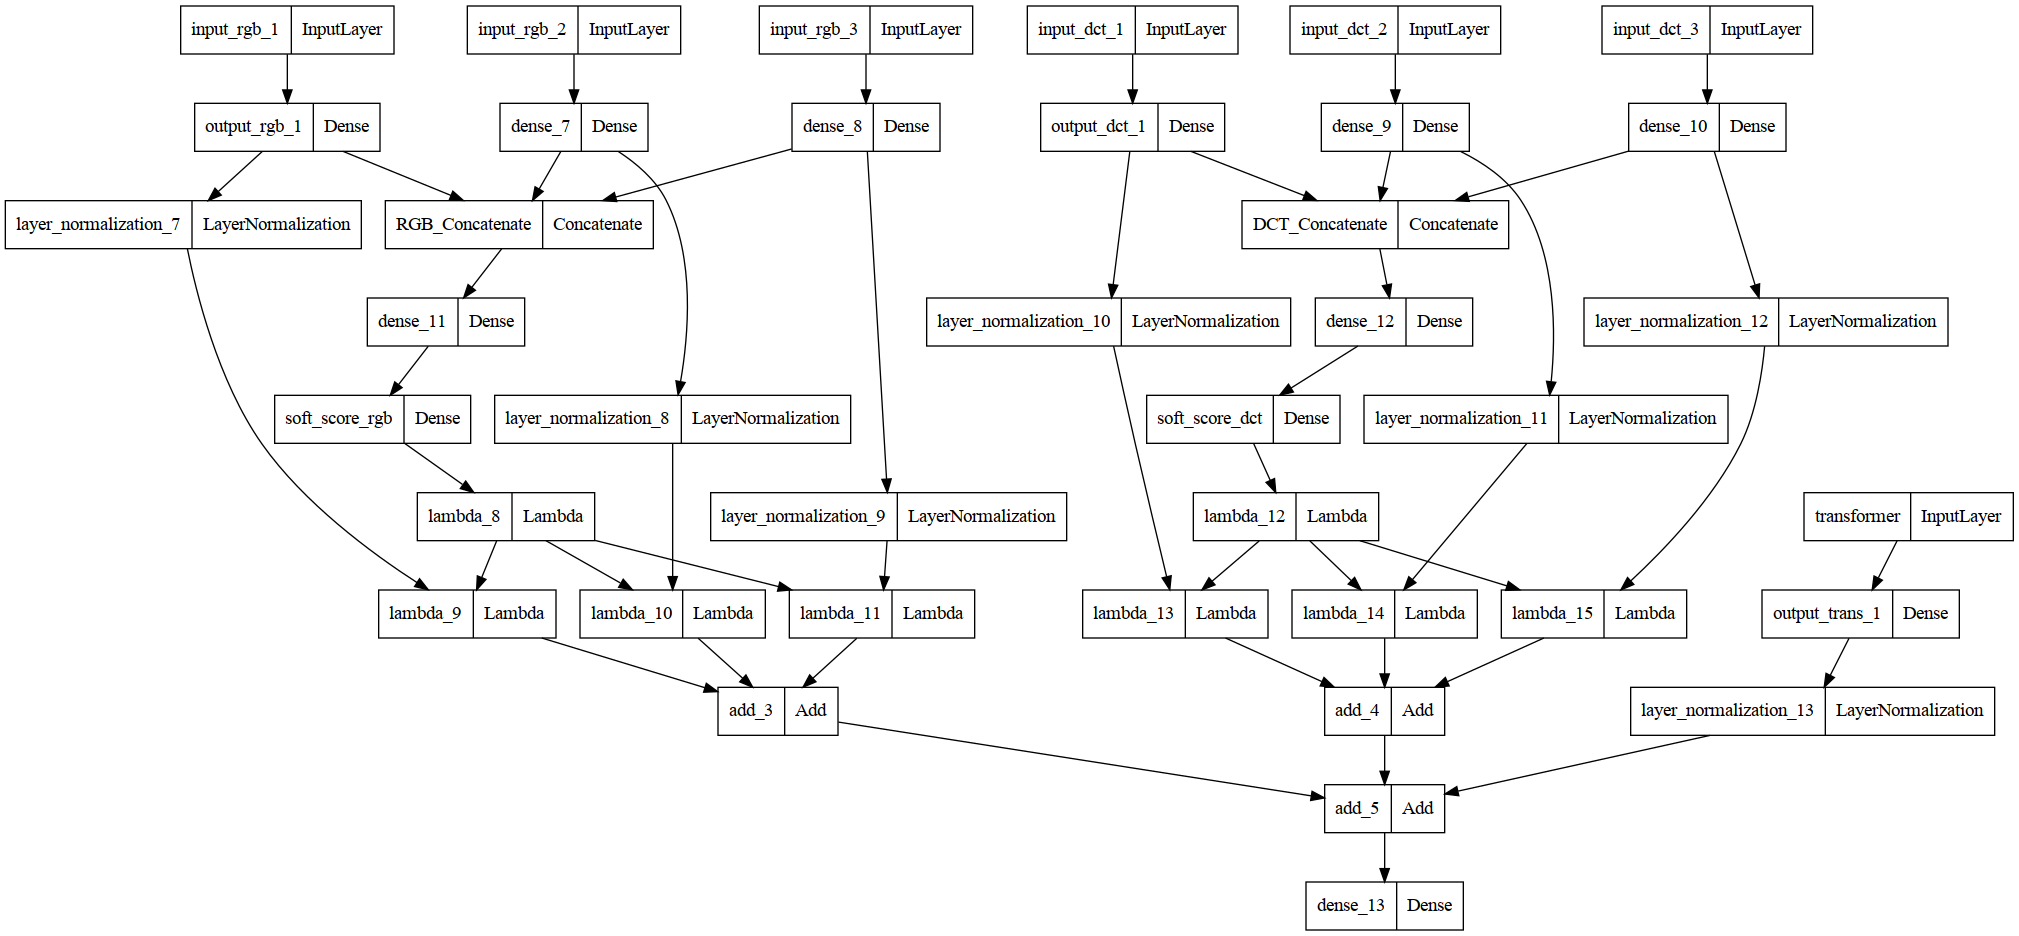

In [10]:
from keras.utils import plot_model
plot_model(final_model, to_file='model12.png')